# ***EE 769 PROJECT ***

# Face Emotion Detection using Conventional neural network

Name: Pooja Saini

Roll No.: 200040100

Associate Prof. Amit Sethi, Electrical Engineering; IIT Bombay

In [2]:
import numpy as np           # linear algebra
import pandas as pd          # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

# 1. Data Overview

In [3]:
#Data Load
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [4]:
#preview first 5 row of data
data.head(5)

#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


<ipython-input-5-24f00b64af8e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


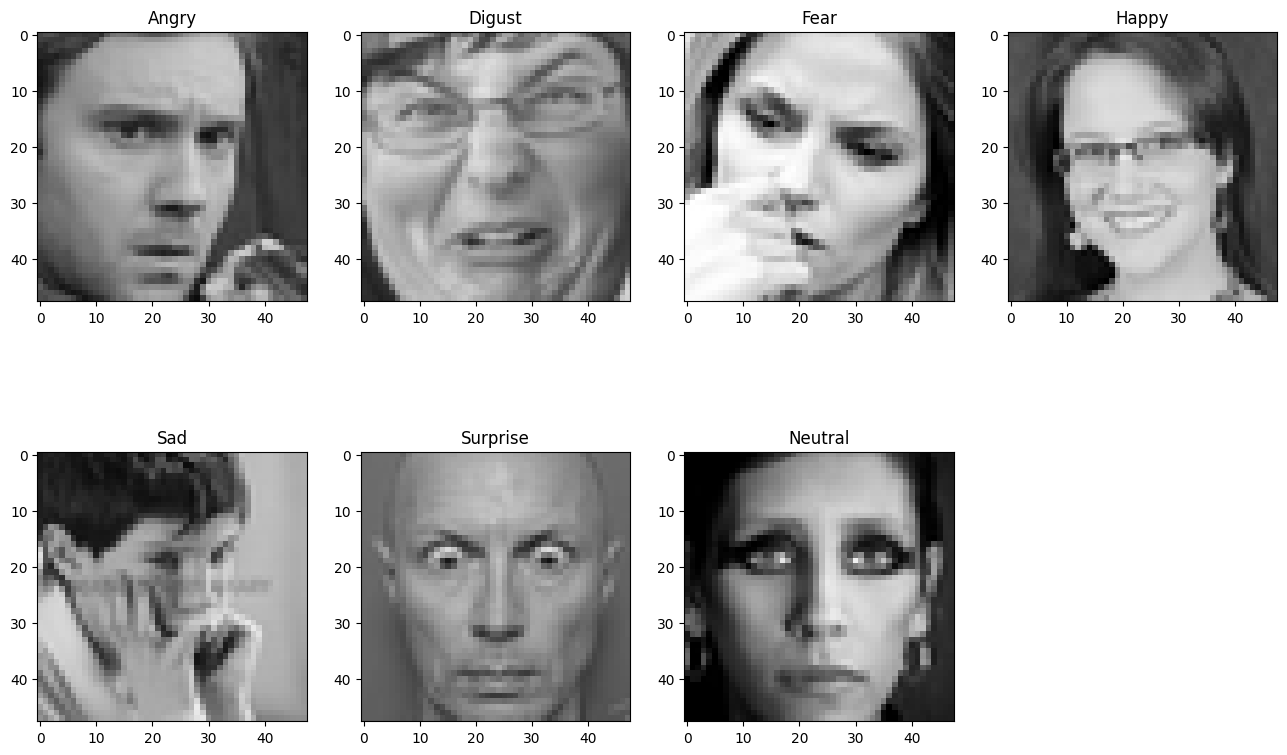

In [5]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show() 

# 2. Pre- Processing Pipe Line

In [6]:
#split data into training, validation and test set
#The input data is split into training, validation, and testing sets using the train_test_split function from the Scikit-Learn library. 
#This ensures that the model is evaluated on unseen data and helps to prevent overfitting.

data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()

In [7]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 20
batch_size = 64
num_features = 64

In [8]:
#The labels for the facial expressions are converted to one-hot encoding using the to_categorical function from the Keras library. 
#This ensures that the labels are in a format that the CNN can use for training and evaluation.
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


# 3. CNN Model

In [9]:
#The input layer receives the input images, which are resized to 48x48 pixels and converted to grayscale.
#The max pooling layers downsample the feature maps by taking the maximum value in each pooling region. 
#This reduces the spatial dimensions of the feature maps and helps to extract the most important features. 
#The code defines two max pooling layers, each with a pool size of 2x2.
#The convolutional layers apply filters to the input images, which extract features such as edges and shapes. 
#The filters are learned during training, and the output of each filter is a feature map. 
#The code defines four convolutional layers, each with 32 filters of size 3x3 and ReLU activation function. 
#The first two convolutional layers also use the input_shape parameter to specify the input size.
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten 
# The flatten layer converts the 2D feature maps into a 1D vector, which can be fed into the fully connected layers.
model.add(Flatten())

#The fully connected layers apply a linear transformation to the input vector, followed by a non-linear activation function. 
#The code defines two fully connected layers, each with 64 neurons and ReLU activation function.
#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
#The output layer produces the final classification of the input image. 
#It has seven neurons, one for each facial expression category, and uses softmax activation function to output the probability distribution of the categories.
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
# data generator to increase accuracy 
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,       # randomly rotate images up to 10 degrees
                        width_shift_range=0.1,   # randomly shift images horizontally up to 10%
                        height_shift_range=0.1,  # randomly shift images vertically up to 10%
                        shear_range=0.1,         # randomly apply shearing transformations
                        zoom_range=.1,           # randomly zoom in on images
                        horizontal_flip=True,    # randomly flip images horizontally
                        fill_mode='nearest'      # fill any empty pixels with the nearest value
                        )


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

#the fit function from the Keras library is used to train the model on the training data

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),  
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

<ipython-input-10-7a6b5a5d5498>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),


Epoch 1/20
448/448 - 65s - loss: 1.7160 - accuracy: 0.3145 - val_loss: 1.7075 - val_accuracy: 0.3277 - 65s/epoch - 144ms/step
Epoch 2/20
448/448 - 46s - loss: 1.4185 - accuracy: 0.4484 - val_loss: 1.8110 - val_accuracy: 0.3455 - 46s/epoch - 101ms/step
Epoch 3/20
448/448 - 44s - loss: 1.2657 - accuracy: 0.5169 - val_loss: 1.3242 - val_accuracy: 0.4876 - 44s/epoch - 98ms/step
Epoch 4/20
448/448 - 45s - loss: 1.1901 - accuracy: 0.5448 - val_loss: 1.3387 - val_accuracy: 0.5258 - 45s/epoch - 101ms/step
Epoch 5/20
448/448 - 46s - loss: 1.1331 - accuracy: 0.5647 - val_loss: 1.2090 - val_accuracy: 0.5411 - 46s/epoch - 102ms/step
Epoch 6/20
448/448 - 46s - loss: 1.0899 - accuracy: 0.5856 - val_loss: 1.2174 - val_accuracy: 0.5531 - 46s/epoch - 103ms/step
Epoch 7/20
448/448 - 46s - loss: 1.0603 - accuracy: 0.5962 - val_loss: 1.1510 - val_accuracy: 0.5656 - 46s/epoch - 103ms/step
Epoch 8/20
448/448 - 46s - loss: 1.0353 - accuracy: 0.6079 - val_loss: 1.0830 - val_accuracy: 0.5979 - 46s/epoch - 102m

# 4. Model Accuracy and Loss  V/S No. of Epoch

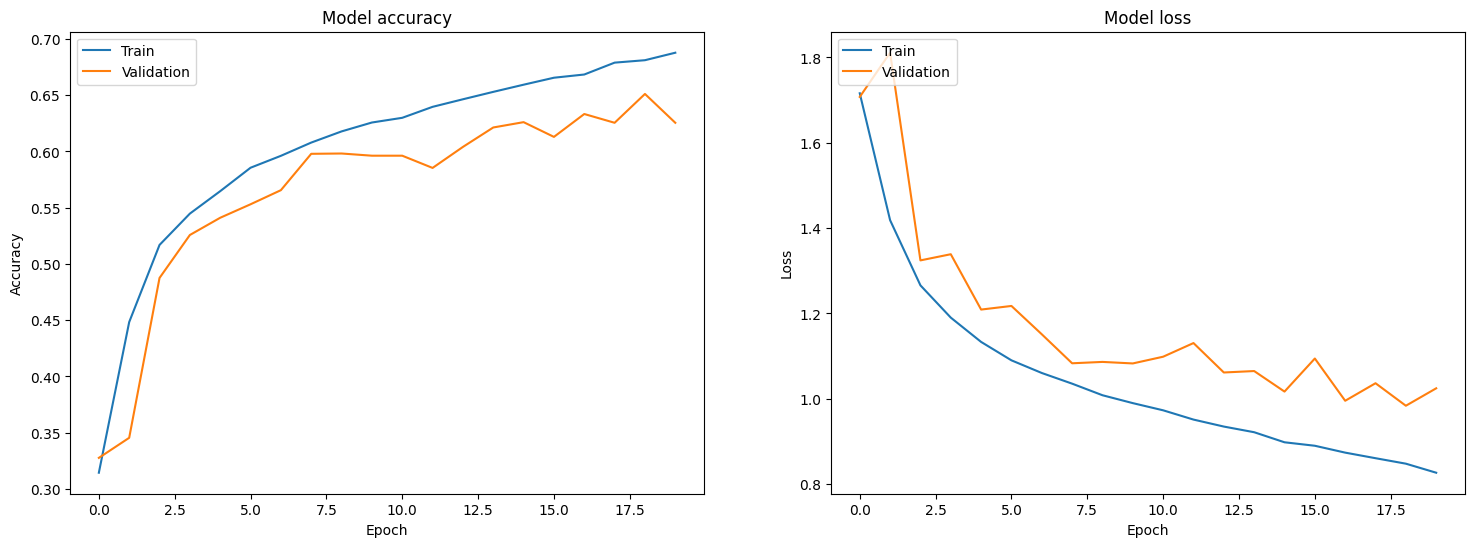

In [11]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
# The loss and accuracy values from the history object are extracted using the history attribute.


#Two plots are created: one for the loss and one for the accuracy. 
#Each plot shows the values for both the training and validation data. 
#The loss plot shows the value of the loss function (in this case, categorical cross-entropy) over each epoch. 
#The accuracy plot shows the classification accuracy of the model over each epoch.

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))


113/113 [==============================] - 2s 15ms/step
CNN Model Accuracy on test set: 0.6417
